In [1]:
import pandas as pd
import itertools as itt
import ppinetsim
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import wasserstein_distance
import networkx as nx
import seaborn as sns
from os.path import join

In [2]:
def _construct_observed_network(parameters):
    edge_list = []
    for sampled_study in parameters.sampled_studies:
        filename = join('ppinetsim', 'data', parameters.test_method, f'{sampled_study}.csv')
        adj_sampled_study = pd.read_csv(filename, index_col=0)
        for edge in itt.product(adj_sampled_study.index, adj_sampled_study.columns):
            if adj_sampled_study.loc[edge]:
                edge_list.append(edge)
    observed_network = nx.Graph()
    observed_network.add_edges_from(edge_list)
    return nx.to_numpy_array(observed_network, dtype=bool)

---
# Sanity check

## 1 FPR = FNR = 0

In [3]:
parameters = ppinetsim.Parameters('parameter_settings/params_AP-MS_FPR00.json')

In [4]:
adj_observed = _construct_observed_network(parameters)
node_degrees_observed = ppinetsim.node_degrees(adj_observed)

In [5]:
node_degrees_simulated_er, _, node_degrees_er, _ = ppinetsim.run_simulation(parameters, verbose=True)

In [6]:
parameters.generator = 'barabasi-albert'

In [7]:
node_degrees_simulated_ba, _, node_degrees_ba, _ = ppinetsim.run_simulation(parameters, verbose=True)

In [8]:
distr_observed = ppinetsim.degrees_to_distribution(node_degrees_observed)
distr_simulated_er = ppinetsim.degrees_to_distribution(node_degrees_simulated_er)
distr_simulated_ba = ppinetsim.degrees_to_distribution(node_degrees_simulated_ba)
distr_er = ppinetsim.degrees_to_distribution(node_degrees_er)
distr_ba = ppinetsim.degrees_to_distribution(node_degrees_ba)

Text(0, 0.5, 'Fraction')

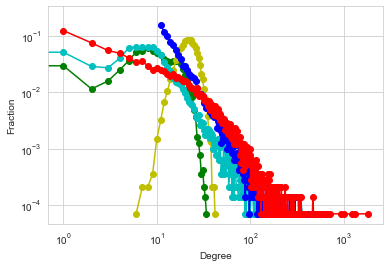

In [9]:
plt.loglog(distr_simulated_er[0,],distr_simulated_er[1,],'go-') # Simulated from ER graph (green)
plt.loglog(distr_er[0,],distr_er[1,],'yo-') # Ground truth ER graph (yellow)
plt.loglog(distr_simulated_ba[0,],distr_simulated_ba[1,],'co-') # Simulated from BA graph (cyan)
plt.loglog(distr_ba[0,],distr_ba[1,],'bo-') # Ground truth BA graph (blue)
plt.loglog(distr_observed[0,],distr_observed[1,],'ro-') # Aggregated PPI network from 91 AP-MS studies with >= 200 PPIs (red)
plt.xlabel('Degree')
plt.ylabel('Fraction')

- **Visual impression:** Using BA as ground (cyan) truth yields distribution that is closer to observed network (red) than using ER as ground truth (green).

In [10]:
wasserstein_distance(distr_simulated_ba[0,], distr_observed[0,], distr_simulated_ba[1,], distr_observed[1,])

11.752584569940929

In [11]:
wasserstein_distance(distr_simulated_er[0,], distr_observed[0,], distr_simulated_er[1,], distr_observed[1,])

13.474365285883934

## 2 FPR = 0.3, FNR = 0.1

In [2]:
parameters = ppinetsim.Parameters('parameter_settings/params_AP-MS_FPR03.json')

In [13]:
node_degrees_simulated_er, _, node_degrees_er, _ = ppinetsim.run_simulation(parameters, verbose=True)

In [14]:
parameters.generator = 'barabasi-albert'

In [15]:
node_degrees_simulated_ba, _, node_degrees_ba, _ = ppinetsim.run_simulation(parameters, verbose=True)

In [16]:
distr_observed = ppinetsim.degrees_to_distribution(node_degrees_observed)
distr_simulated_er = ppinetsim.degrees_to_distribution(node_degrees_simulated_er)
distr_simulated_ba = ppinetsim.degrees_to_distribution(node_degrees_simulated_ba)
distr_er = ppinetsim.degrees_to_distribution(node_degrees_er)
distr_ba = ppinetsim.degrees_to_distribution(node_degrees_ba)

Text(0, 0.5, 'Fraction')

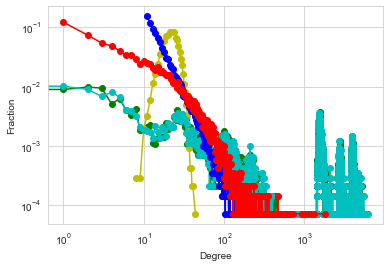

In [17]:
plt.loglog(distr_simulated_er[0,],distr_simulated_er[1,],'go-') # Simulated from ER graph (green)
plt.loglog(distr_er[0,],distr_er[1,],'yo-') # Ground truth ER graph (yellow)
plt.loglog(distr_simulated_ba[0,],distr_simulated_ba[1,],'co-') # Simulated from BA graph (cyan)
plt.loglog(distr_ba[0,],distr_ba[1,],'bo-') # Ground truth BA graph (blue)
plt.loglog(distr_observed[0,],distr_observed[1,],'ro-') # Aggregated PPI network from 91 AP-MS studies with >= 200 PPIs (red)
plt.xlabel('Degree')
plt.ylabel('Fraction')

In [18]:
wasserstein_distance(distr_simulated_ba[0,], distr_observed[0,], distr_simulated_ba[1,], distr_observed[1,])

1917.0675856248263

In [19]:
wasserstein_distance(distr_simulated_er[0,], distr_observed[0,], distr_simulated_er[1,], distr_observed[1,])

1919.34946198743

---
# Usage of Bayesian inference module

In [2]:
# Test parameters for simulations that terminate quickly (only for testing)
parameters = ppinetsim.Parameters('parameter_settings/params_test.json')

In [3]:
# I used num_simulations_per_generator=2 such that the code terminates quickly.
# Would set this parameter to at least 10 for the real tests.
# Overall number of simulations per call to estimate_likelihood() is 2 * num_simulations_per_generator.
# See docstring for explanation of data contained in all_results.
likelihood_at_k, all_results = ppinetsim.estimate_likelihood(parameters, num_simulations_per_generator=2)

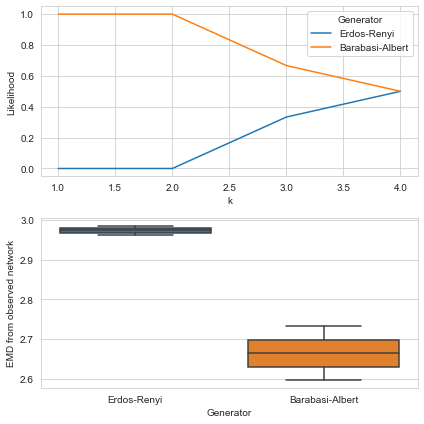

In [10]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(6,6))
ppinetsim.plot_likelihoods(likelihood_at_k, ax=axes[0])
ppinetsim.plot_distances(all_results, kind='box',ax=axes[1])
fig.tight_layout()

<AxesSubplot:xlabel='k', ylabel='Likelihood'>

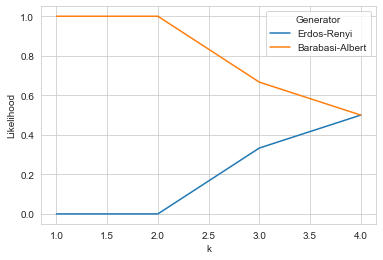

In [10]:
ppinetsim.plot_likelihoods(likelihood_at_k, ax=axes[0])

<AxesSubplot:xlabel='Generator', ylabel='EMD from observed network'>

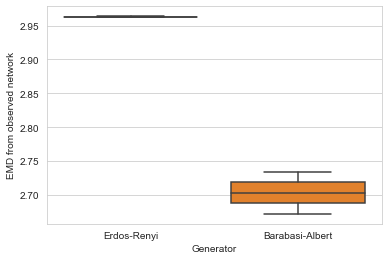

In [11]:
ppinetsim.plot_distances(all_results, kind='box',ax=axes[1])

<AxesSubplot:xlabel='Generator', ylabel='EMD from observed network'>

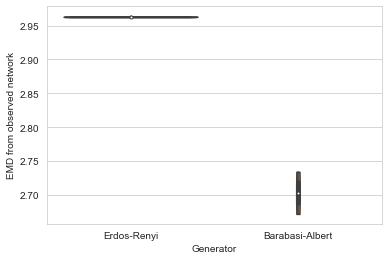

In [12]:
ppinetsim.plot_distances(all_results, kind='violin')